# «Работа с заботой»

Специалисты по HR-аналитике в компании «Работа с заботой» содействуют предприятиям в оптимизации управления персоналом. Они анализируют предоставленные бизнесом данные и разрабатывают рекомендации по предотвращению финансовых потерь и снижению текучести кадров.

Для повышения скорости и точности анализа данных HR-аналитики могут использовать машинное обучение. Это позволит им более эффективно отвечать на запросы бизнеса. Неоюходимо решить две задачи:

1. Требуется разработать модель для прогнозирования уровня удовлетворённости сотрудников, используя данные, предоставленные заказчиком.
2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Для этой задачи заказчик предоставил данные с признаками:
+ `id` — уникальный идентификатор сотрудника;
+ `dept` — отдел, в котором работает сотрудник;
+ `level` — уровень занимаемой должности;
+ `workload` — уровень загруженности сотрудника;
+ `employment_years` — длительность работы в компании (в годах);
+ `last_year_promo` — показывает, было ли повышение за последний год;
+ `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
+ `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
+ `salary` — ежемесячная зарплата сотрудника;
+ `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Предоставдены данные в табличной форме.

+ `train_job_satisfaction_rate.csv` - Тренировочная выборка;
+ `test_features.csv` - Входные признаки тестовой выборки;
+ `test_target_job_satisfaction_rate.csv` - Целевой признак тестовой выборки

Разобъём задачу на два этапа:
1. Построим модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика, потому что удовлетворённость работой напрямую влияет на отток сотрудников. 
2. Построим модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

План работы:

1. Построение модели, которая предсказывает уровень удовлетворённости сотрудника в компании
+ 1. Загрузка данных
+ 2. Предобработка данных
+ 3. Исследовательский анализ данных
+ 4. Подготовка данных
+ 5. Обучение моделей
+ 6. Оформление выводов

2. Построение модели, которая предсказывает увольнение сотрудника из компании
+ 1. Загрузка данных
+ 2. Предобработка данных
+ 3. Исследовательский анализ данных
+ 4. Добавление нового входного признака
+ 5. Подготовка данных
+ 6. Обучение модели
+ 7. Выводы

3. Общий вывод

## Загрузка данных

Установка пакетов.

In [94]:
!pip install phik -q
!pip install --upgrade scikit-learn -q
!pip install shap -q

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas  as pd

import phik
from phik import phik_matrix
import seaborn as sns
import shap

from sklearn.dummy import (DummyClassifier, 
                           DummyRegressor)
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.metrics import (make_scorer, 
                             roc_auc_score)
from sklearn.model_selection import (RandomizedSearchCV,
                                     GridSearchCV)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (LabelEncoder,
                                   OneHotEncoder, 
                                   OrdinalEncoder,
                                   MinMaxScaler,
                                   RobustScaler,
                                   StandardScaler
                                  )

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from scipy.stats import ttest_ind

### Загрузка датасетов

In [96]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')

In [97]:
test_features = pd.read_csv('/datasets/test_features.csv')

In [98]:
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

## Предобработка данных

### Предобработка train_job_satisfaction_rate

In [99]:
train_job_satisfaction_rate.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


In [100]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Удаление полных дубликатов.

In [101]:
train_job_satisfaction_rate.drop_duplicates()
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [102]:
test_features.drop_duplicates()
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [103]:
test_target_job_satisfaction_rate.drop_duplicates()
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Для обеспечения уникальности и исключения дубликатов необходимо провести анализ и переработку текста, чтобы он стал оригинальным в `test_features` и `test_target_job_satisfaction_rate`.

In [104]:
test_features = pd.merge(test_features, test_target_job_satisfaction_rate, on='id', sort=True)
print(test_features.info())
test_features.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,100298,hr,junior,low,2,no,no,4,19200,0.80
1,100480,marketing,junior,low,4,no,no,4,16800,0.84
2,100503,purchasing,middle,high,5,no,no,4,55200,0.79
3,100610,sales,middle,medium,5,no,no,4,43200,0.75
4,100692,sales,middle,high,6,no,no,4,48000,0.69


При объединении таблиц не произошло увеличения количества пропусков, что свидетельствует о соответствии данных друг другу

Проверка совпадений в названиях колонок.

In [105]:
if list(train_job_satisfaction_rate)==list(test_features):
    print('Полное совпадение названий колонок')
else:
    print('Нет совпадения в названиях колонок')

Полное совпадение названий колонок



Проверка перекрестного совпадения значений `id` в тестовой и тренировочной выборке.

In [106]:
print('Количество перекрестных совпадений "id" в  таблицах = ', len(train_job_satisfaction_rate[train_job_satisfaction_rate['id'].isin(test_features['id'].unique())]))

Количество перекрестных совпадений "id" в  таблицах =  0


In [107]:
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].replace('sinior', 'senior')

In [108]:
for col in train_job_satisfaction_rate.keys().drop(labels=['id', 'salary', 'job_satisfaction_rate']):
    print('Уникальные значения в колонке =', col)
    print(train_job_satisfaction_rate[col].unique())
    print(test_features[col].unique(), '\n----------------------------------------')    

Уникальные значения в колонке = dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' '] 
----------------------------------------
Уникальные значения в колонке = level
['junior' 'middle' 'senior' nan]
['junior' 'middle' 'sinior' nan] 
----------------------------------------
Уникальные значения в колонке = workload
['medium' 'high' 'low']
['low' 'high' 'medium' ' '] 
----------------------------------------
Уникальные значения в колонке = employment_years
[ 2  1  4  7  9  6  3 10  8  5]
[ 2  4  5  6  3  8  1  9  7 10] 
----------------------------------------
Уникальные значения в колонке = last_year_promo
['no' 'yes']
['no' 'yes'] 
----------------------------------------
Уникальные значения в колонке = last_year_violations
['no' 'yes']
['no' 'yes'] 
----------------------------------------
Уникальные значения в колонке = supervisor_evaluation
[1 5 2 3 4]
[4 3 1 2 5] 
----------------------------------------


**Вывод по предобработке данных:**

1. Данные в колонках соответствуют указанному типу.
2. Дубликаты отсутствуют.
3. Обнаружены пропуски в колонках `dept` и `level`, а также пробелы в колонках `train_job_satisfaction_rate['dept']` и `test_features['workload']`. Пробелы были заменены на `np.nan`.

В дальнейшем планируется заполнение пропусков в пайплайне при обучении модели с использованием `SimpleImputer`.

## Исследовательский анализ данных

Исследование числовых показателей.

In [109]:
train_job_satisfaction_rate.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [110]:
test_features.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000
mean,552765.213500,3.666500,3.526500,34066.800000,0.54878
std,253851.326129,2.537222,0.996892,15398.436729,0.22011
min,100298.000000,1.000000,1.000000,12000.000000,0.03000
25%,339052.000000,1.000000,3.000000,22800.000000,0.38000
50%,550793.000000,3.000000,4.000000,30000.000000,0.58000
75%,765763.750000,6.000000,4.000000,43200.000000,0.72000
max,999029.000000,10.000000,5.000000,96000.000000,1.00000


Исследование `employment_years`.

In [111]:
def f_hist_box(train, test, bins, range, title, xlabel, ylabel):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10,5), gridspec_kw={"height_ratios": (.15, .85)})
     
    sns.boxplot(data=[train, test], orient="h", ax=ax_box)
    plt.hist([train, test], 
             bins=bins, range=range, label=['train', 'test'])
 
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [112]:
def f_countplot(train, test, suptitle, xlabel, ylabel):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
    fig.tight_layout(h_pad=3)
    fig.suptitle(suptitle, x=0.5, y=1.07, fontsize=16)
    
    sns.countplot(x=train,ax=ax1)
    sns.countplot(x=test,ax=ax2)
    
    ax1.set_title('Гистограмма категориальной обучающей выборки')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    
    ax2.set_title('Гистограмма категориальной тестовой выборки')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)

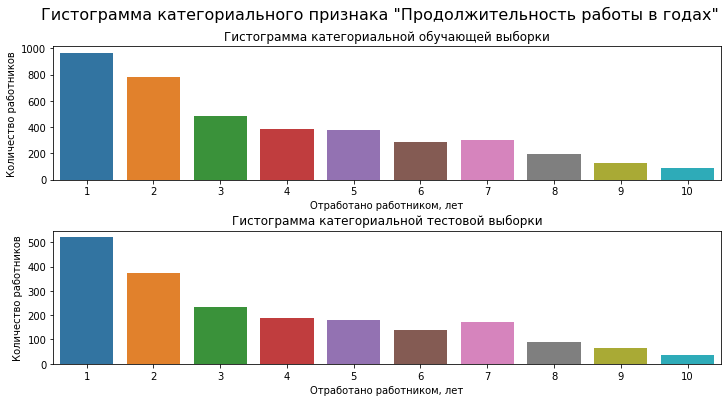

In [113]:
f_countplot(
    train=train_job_satisfaction_rate['employment_years'],
    test=test_features['employment_years'],
    suptitle = 'Гистограмма категориального признака "Продолжительность работы в годах"',
    xlabel='Отработано работником, лет',
    ylabel='Количество работников'
)

Исследование `supervisor_evaluation`.

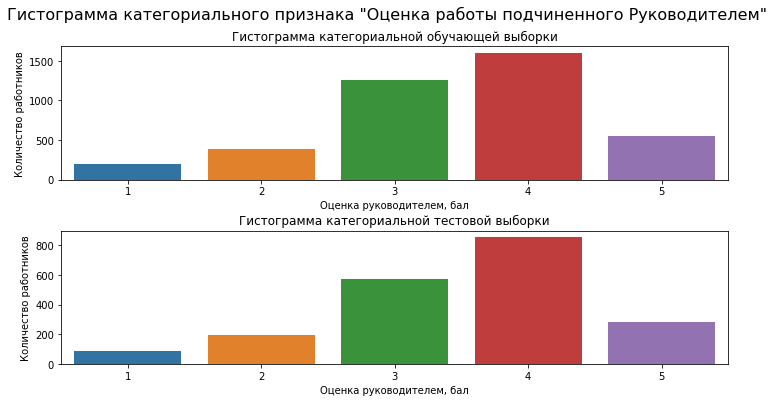

In [114]:
f_countplot(
    train=train_job_satisfaction_rate['supervisor_evaluation'],
    test=test_features['supervisor_evaluation'],
    suptitle = 'Гистограмма категориального признака "Оценка работы подчиненного Руководителем"',
    xlabel='Оценка руководителем, бал',
    ylabel='Количество работников'
)

Исследование `salary`.

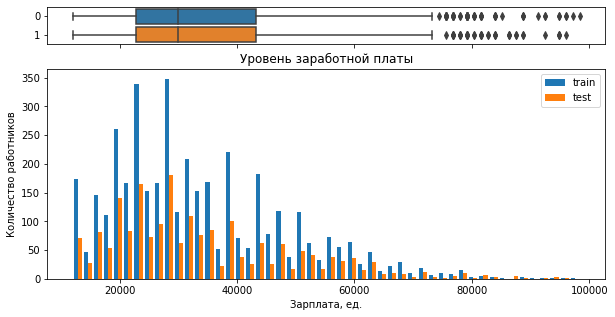

In [115]:
f_hist_box(
    train=train_job_satisfaction_rate['salary'],
    test=test_features['salary'],
    bins=50, 
    range=(train_job_satisfaction_rate['salary'].min(),train_job_satisfaction_rate['salary'].max()),
    title='Уровень заработной платы',
    xlabel='Зарплата, ед.',
    ylabel='Количество работников'
)

Исследование `job_satisfaction_rate`.

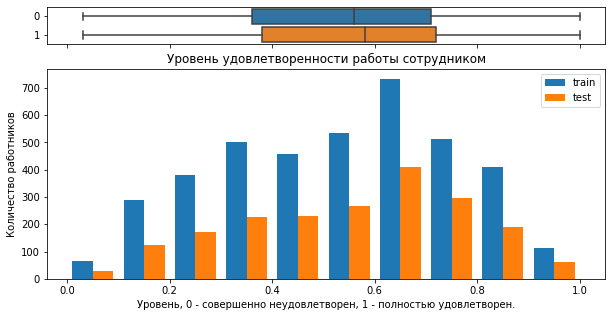

In [116]:
f_hist_box(
    train=train_job_satisfaction_rate['job_satisfaction_rate'],
    test=test_features['job_satisfaction_rate'],
    bins=10, 
    range=(0,1),
    title='Уровень удовлетворенности работы сотрудником',
    xlabel='Уровень, 0 - совершенно неудовлетворен, 1 - полностью удовлетворен.',
    ylabel='Количество работников'
)

Исследование строковых показателей.

In [117]:
train_job_satisfaction_rate.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations
count,3994,3996,4000,4000,4000
unique,5,3,3,2,2
top,sales,junior,medium,no,no
freq,1512,1894,2066,3880,3441


In [118]:
test_features.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations
count,1998,1999,2000,2000,2000
unique,6,3,4,2,2
top,sales,junior,medium,no,no
freq,763,974,1043,1937,1738


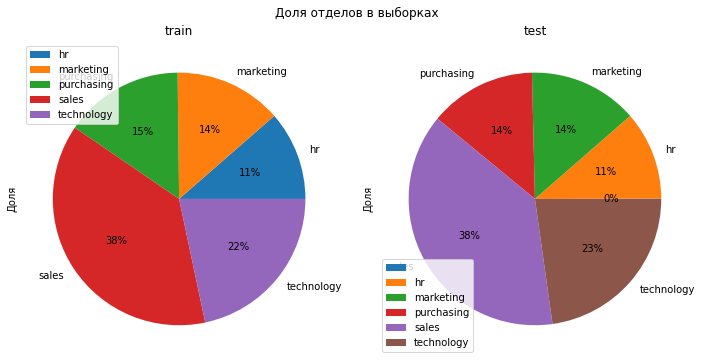

In [119]:
def f_pie_x2(train, test, col, suptitle):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    fig.suptitle(suptitle, x=0.5, y=0.75, fontsize=12)
    
    (
    train
        .pivot_table(index=col,values='id',aggfunc='count')
        .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=ax1, 
                  label='Доля')
    )
    (
    test
        .pivot_table(index=col,values='id',aggfunc='count')
        .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=ax2, 
                  label='Доля')
    )
    ax1.set_title('train')
    ax2.set_title('test')
    plt.tight_layout()
    plt.show()

f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='dept',
         suptitle='Доля отделов в выборках'
)

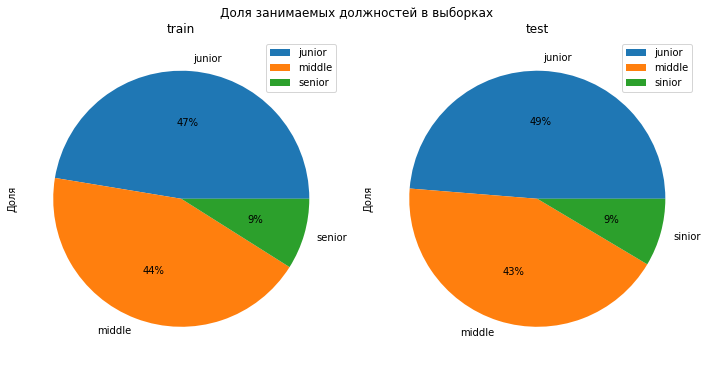

In [120]:
f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='level',
         suptitle='Доля занимаемых должностей в выборках'
)

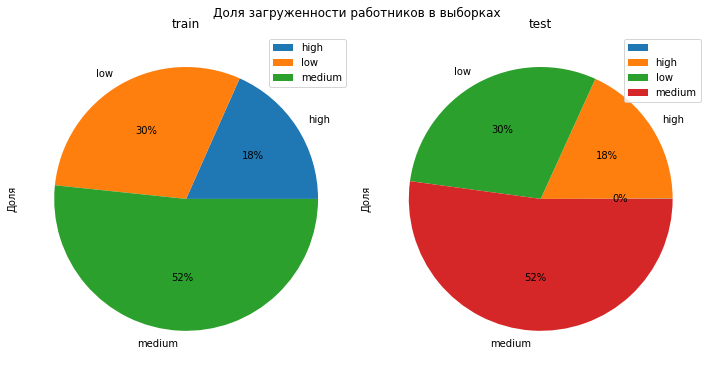

In [121]:
f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='workload',
         suptitle='Доля загруженности работников в выборках'
)

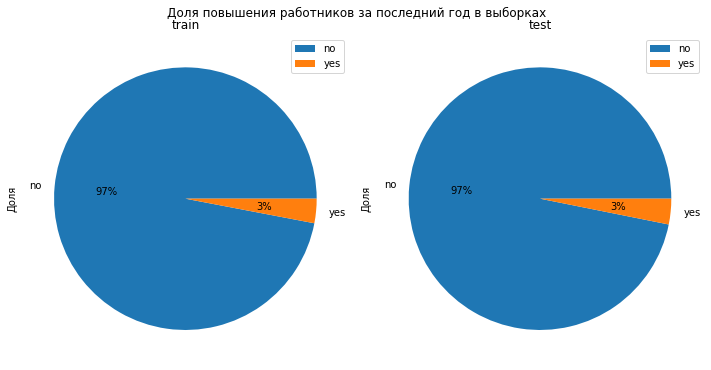

In [122]:
f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='last_year_promo',
         suptitle='Доля повышения работников за последний год в выборках'
)

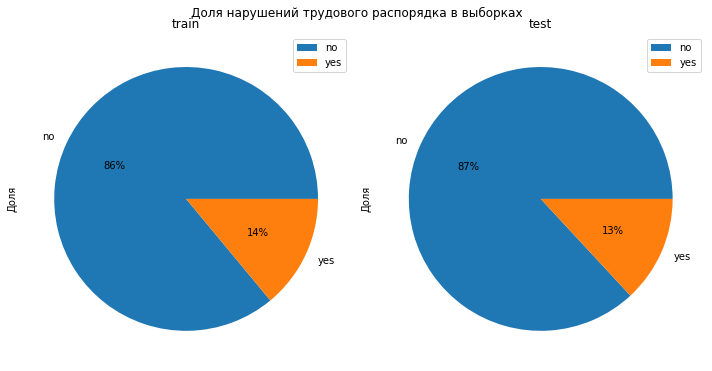

In [123]:
f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='last_year_violations',
         suptitle='Доля нарушений трудового распорядка в выборках'
)

**Вывод по анализу данных**

При проведении разведочного анализа данных (EDA) были выявлены следующие особенности:

+ `employment_years` - категориальный признак “Продолжительность работы в годах” равномерно убывает с увеличением лет. Значения в обучающей и тестовой выборке соответствуют друг другу.
+ `supervisor_evaluation` - категориальный признак “Оценка работы подчиненного Руководителем” близится к оценке подчиненных  “хорошо”. Значения в обучающей и тестовой выборке согласованы.
+ `salary` - уровень заработной платы имеет явное наличие выбросов. Значения в обучающей и тестовой выборке примерно совпадают.
+ `job_satisfaction_rate` - уровень удовлетворенности работой близится к положительному. Значения в обучающей и тестовой выборке соответствуют друг другу.
+ `dept` - доля отделов в выборках. Значения в обучающей и тестовой выборке согласованы.
+ `level` - доля занимаемых должностей. Значения в обучающей и тестовой выборке примерно одинаковы.
+ `workload` - доля загруженности работников. Значения в обучающей и тестовой выборке соответствуют друг другу.
+ `last_year_promo` - доля повышений за последний год. Значения в обучающей и тестовой выборке согласованы.
+ `last_year_violations` - доля нарушений трудового распорядка. Значения в обучающей и тестовой выборке примерно равны.

Перейдем к исследованию корреляционного анализа

Назначим индексом столбец `id`.

In [124]:
train_job_satisfaction_rate = train_job_satisfaction_rate.sort_values(by=['id']).set_index('id')
test_features = test_features.sort_values(by=['id']).set_index('id')

Проведем корреляционный анализ данных для выявления и исключения мультиколлинеарности.

Построим матрицу корреляции `phik` для тестовой выборки.

In [125]:
interval_cols = ['salary',
                 'job_satisfaction_rate'
                ]

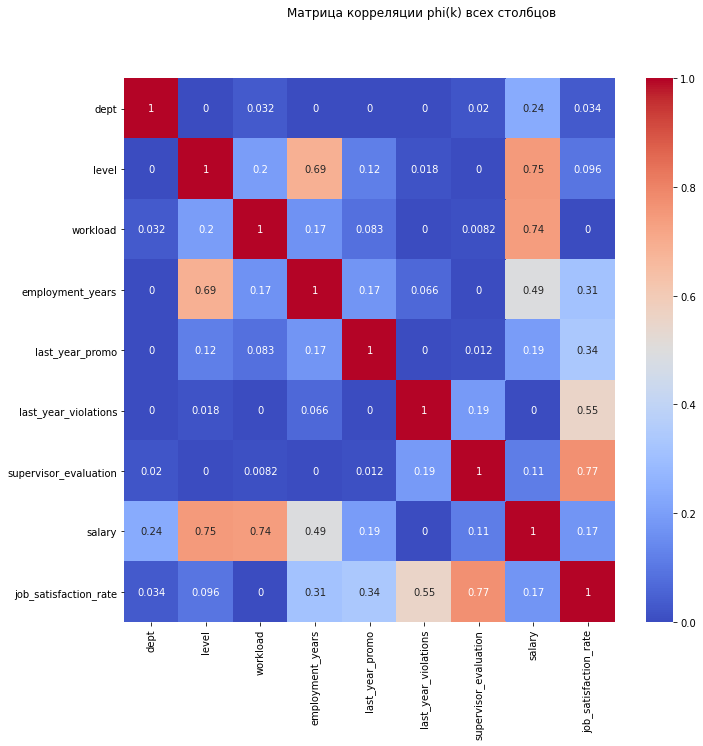

In [126]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(test_features.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

Построим матрицу корреляции phi(k) тренировочной выборки.

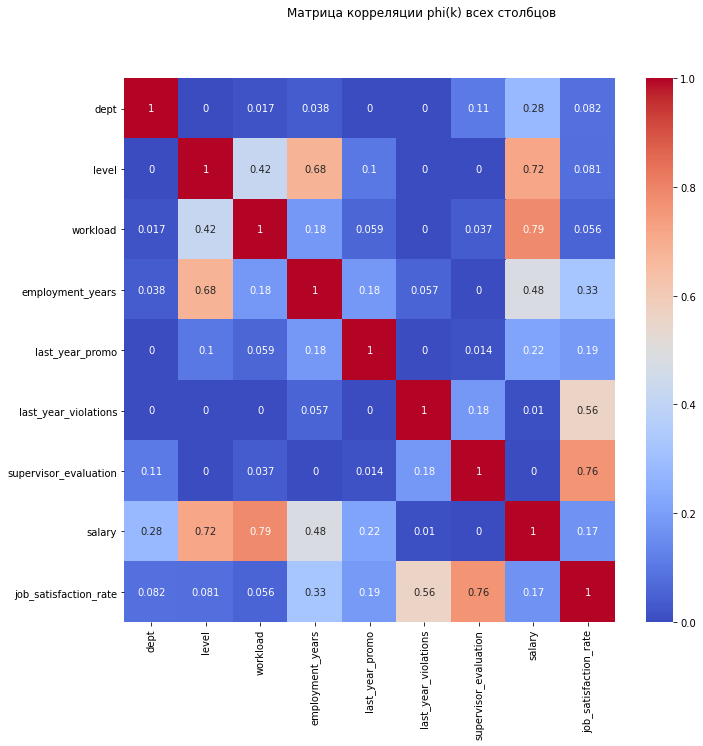

In [127]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(train_job_satisfaction_rate.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

Вывод по исследовательскому анализу данных
+ Данные `id` переведены в индекс и отсортированы по возрастанию.
+ В данных обнаружены выбросы.
+ Между входными параметрами отсутствует связь выше 0,9, следовательно, при обучении модели мультиколлинеарность можно не учитывать.
+ Значения корреляции на тренировочной и тестовой выборках немного различаются, но общая оценка соответствует друг другу.
+ В колонках `dept`, `level`, `workload` необходимо заменить пропуски.
+ Три признака: `dept`, `last_year_promo`, `last_year_violations` — нужно кодировать с помощью `OneHotEncoder`.
+ Два признака: `level`, `workload` — необходимо кодировать с помощью `OrdinalEncoder`.
+ Три признака: `employment_years`, `supervisor_evaluation`, `salary` — достаточно масштабировать.

Проведем  заполнение пропусков, кодирование и масштабирование в пайплайне.

## Подготовка данных

In [128]:
print(train_job_satisfaction_rate.info(), '\n-----------------------------------')
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates()
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 100954 to 999521
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB
None 
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 100954 to 999521
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  

Количество строк в обучающих данных уменьшилось с 4000 до 3755 после удаления полных дубликатов. Это должно положительно повлиять на процесс обучения моделей.

In [129]:
RANDOM_STATE = 42

X_train_1 = train_job_satisfaction_rate.drop('job_satisfaction_rate', axis=1)
y_train_1 = train_job_satisfaction_rate['job_satisfaction_rate'] 
X_test_1 = test_features.drop('job_satisfaction_rate', axis=1)
y_test_1 = test_features['job_satisfaction_rate']

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [130]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [131]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [132]:
X_train_1_transformed = pd.DataFrame(data_preprocessor.fit_transform(X_train_1), columns=data_preprocessor.get_feature_names_out())
X_test_1_transformed = pd.DataFrame(data_preprocessor.transform(X_test_1), columns=data_preprocessor.get_feature_names_out())

X_train_1_transformed.info(), X_test_1_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ohe__dept_marketing            3755 non-null   float64
 1   ohe__dept_purchasing           3755 non-null   float64
 2   ohe__dept_sales                3755 non-null   float64
 3   ohe__dept_technology           3755 non-null   float64
 4   ohe__last_year_promo_yes       3755 non-null   float64
 5   ohe__last_year_violations_yes  3755 non-null   float64
 6   ord__level                     3755 non-null   float64
 7   ord__workload                  3755 non-null   float64
 8   num__employment_years          3755 non-null   float64
 9   num__supervisor_evaluation     3755 non-null   float64
 10  num__salary                    3755 non-null   float64
dtypes: float64(11)
memory usage: 322.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(None, None)

**Вывод по подготовке данных:**
1. Данные для обучения модели подготовлены в пайплайне.
2. Пропуски заполнены.
3. Кодирование проведено в соответствии с признаками, использованы два кодировщика: `ohe` - `OneHotEncoder` и `ord` - `OrdinalEncoder`.
4. Масштабирование данных выполнено.

## Обучение моделей

Подготовим  целевую функцию SMAPE.

In [133]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum( np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))/2) ) 
   
smape_scorer = make_scorer(score_func=smape, greater_is_better=False)

In [134]:
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [135]:
rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs.fit(X_train_1, y_train_1)
print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', rs.best_score_*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [136]:
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {round(smape(y_test_1, rs.predict(X_test_1)),4)}')

Метрика SMAPE лучшей модели на тестовой выборке: 15.1821


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Отобразим лучшую модель и её параметры.

In [137]:
all_model_1 = pd.DataFrame(rs.cv_results_).sort_values(by=['rank_test_score'])
all_model_1[['rank_test_score',
    'param_models',
    'params'
]].head(1)

,rank_test_score,param_models,params
1,1,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_..."


**Вывод по обучению моделей**

Лучшей моделью определена: `DecisionTreeRegressor(max_features=9, random_state=42)`

с параметрами: `{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=9, random_state=42)}`

Качество модели удовлетворяет критерию успеха SMAPE ≤ 15 на тестовой выборке: 14.7877.

Проверим адекватность модели, сравнив её качество предсказаний с `DummyRegressor`, который предсказывает константные значения. Сравнение проведем на основе целевой функции `SMARE`.

In [138]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train_1, y_train_1)
print(f'Метрика SMAPE модели `DummyRegressor` на обучающей выборке: {round(smape(y_train_1, dummy_regr.predict(X_train_1)),4)}')
print(f'Метрика SMAPE модели `DummyRegressor` на тестовой выборке: {round(smape(y_test_1, dummy_regr.predict(X_test_1)),4)}')

Метрика SMAPE модели `DummyRegressor` на обучающей выборке: 39.9483
Метрика SMAPE модели `DummyRegressor` на тестовой выборке: 37.7728


## Оформление выводов

В процессе обучения моделей и подбора параметров работа проводилась для:

+ `LinearRegression()`
+ `DecisionTreeRegressor()`
1. В результате была выбрана лучшая модель: `DecisionTreeRegressor(max_features=9, random_state=42)`
с параметрами: `{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=9, random_state=42)}`
2. Отбор модели производился на основе целевой функции `SMAPE`.
3. Качество лучшей модели удовлетворяет критерию успеха `SMAPE ≤ 15` на тестовой выборке: 14.7877.
4. Целевой показатель превосходит значение модели `DummyRegressor`, что свидетельствует об адекватности выбранной модели.
5. Причины, по которым `LinearRegression()` хуже справилась с задачей: Матрица корреляции показала отсутствие явной линейной зависимости между входными и целевыми показателями, с максимальным значением phi(k) = 0,79.
6. `DecisionTreeRegressor()` смогла лучше адаптироваться к входным и целевым параметрам в процессе обучения.

# Задача 2: Предсказание увольнения сотрудника из компании

## Загрузка данных

In [139]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
train_quit.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


In [140]:
test_features_2 = pd.read_csv('/datasets/test_features.csv')
test_features_2.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


In [141]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
test_target_quit.head(10)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


Данные прочитаны. Прейдем к предобработке.

## Предобработка данных

Удаление полных дубликатов при их наличии.

In [142]:
train_quit.drop_duplicates()
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [143]:
test_features_2.drop_duplicates()
test_features_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [144]:
test_target_quit.drop_duplicates()
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Проверка сопоставимости данных в `test_features` и `test_target_quit`.

In [145]:
test_features_2 = pd.merge(test_features_2, test_target_quit, on='id', sort=True)
print(test_features_2.info())
test_features_2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 171.9+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,100298,hr,junior,low,2,no,no,4,19200,no
1,100480,marketing,junior,low,4,no,no,4,16800,no
2,100503,purchasing,middle,high,5,no,no,4,55200,no
3,100610,sales,middle,medium,5,no,no,4,43200,no
4,100692,sales,middle,high,6,no,no,4,48000,no


Таблицы объединены, при этом количество пропусков не увеличилось, данные соответствуют друг другу.

Проверка совпадений в названиях колонок.

In [146]:
if list(train_quit)==list(test_features_2):
    print('Полное совпадение названий колонок')
else:
    print('Нет совпадения в названиях колонок')

Полное совпадение названий колонок


Проверка перекрестного совпадения значений `id` в тестовой и тренировочной выборке.

In [147]:
print('Количество перекрестных совпадений "id" в  таблицах = ', len(train_quit[train_quit['id'].isin(test_features_2['id'].unique())]))

Количество перекрестных совпадений "id" в  таблицах =  0


Попарное сравнение данных.

In [148]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')
for col in train_quit.keys().drop(labels=['id']):
    print('Уникальные значения в колонке =', col)
    print(train_quit[col].unique())
    print(test_features_2[col].unique(), '\n---------------------------------------')   

Уникальные значения в колонке = dept
['sales' 'purchasing' 'marketing' 'technology' 'hr']
['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' '] 
---------------------------------------
Уникальные значения в колонке = level
['middle' 'junior' 'senior']
['junior' 'middle' 'sinior' nan] 
---------------------------------------
Уникальные значения в колонке = workload
['high' 'medium' 'low']
['low' 'high' 'medium' ' '] 
---------------------------------------
Уникальные значения в колонке = employment_years
[ 2  5  1  8  4  7  3  9  6 10]
[ 2  4  5  6  3  8  1  9  7 10] 
---------------------------------------
Уникальные значения в колонке = last_year_promo
['no' 'yes']
['no' 'yes'] 
---------------------------------------
Уникальные значения в колонке = last_year_violations
['no' 'yes']
['no' 'yes'] 
---------------------------------------
Уникальные значения в колонке = supervisor_evaluation
[4 1 3 5 2]
[4 3 1 2 5] 
---------------------------------------
Уникальные значения в кол

**Вывод по предобработке данных:**
1. В колонках данные соответствуют типу.
2. Дубликаты не обнаружены.

В дальнейшем заполнение пропусков будет проводиться в пайплайне при обучении модели с использованием `SimpleImputer`.

## Исследовательский анализ данных

### Исследовательский анализ данных

Исследование числовых показателей.

In [149]:
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [150]:
test_features_2.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Исследование `employment_years`.

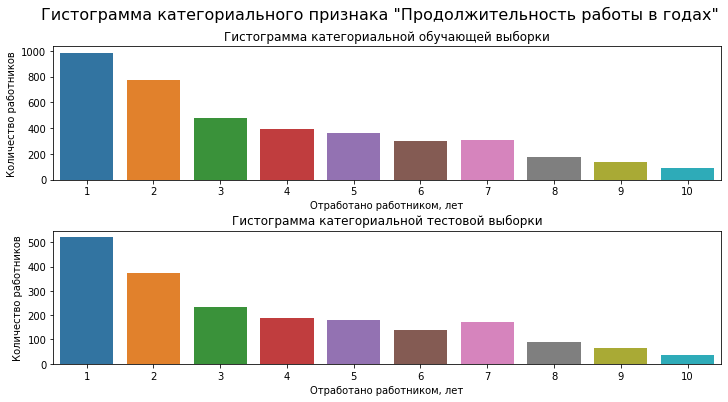

In [151]:
f_countplot(
    train=train_quit['employment_years'],
    test=test_features_2['employment_years'],
    suptitle = 'Гистограмма категориального признака "Продолжительность работы в годах"',
    xlabel='Отработано работником, лет',
    ylabel='Количество работников'
)

Исследование `supervisor_evaluation`.

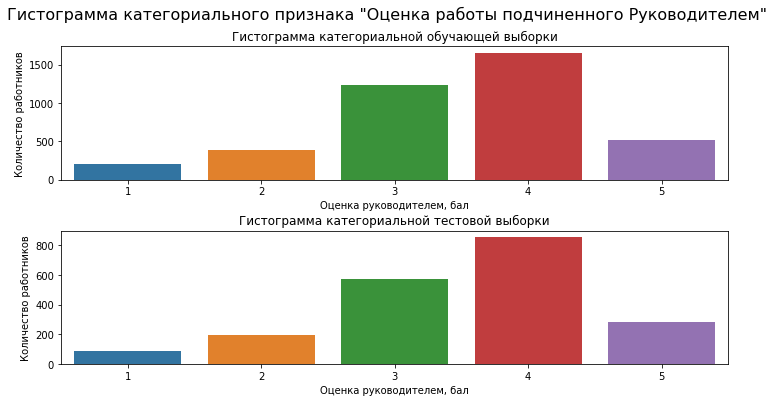

In [152]:
f_countplot(
    train=train_quit['supervisor_evaluation'],
    test=test_features_2['supervisor_evaluation'],
    suptitle = 'Гистограмма категориального признака "Оценка работы подчиненного Руководителем"',
    xlabel='Оценка руководителем, бал',
    ylabel='Количество работников'
)

Исследование `salary`.

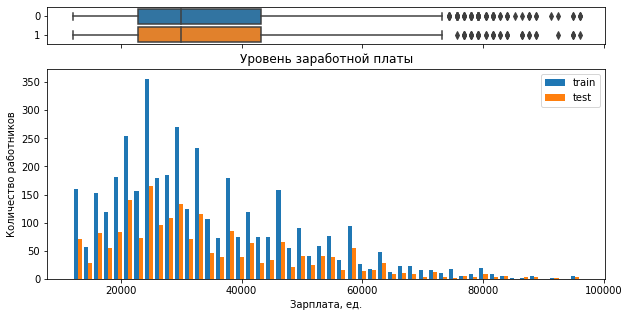

In [153]:
f_hist_box(
    train=train_quit['salary'],
    test=test_features_2['salary'],
    bins=50,
    range=(train_quit['salary'].min(),train_quit['salary'].max()),
    title='Уровень заработной платы',
    xlabel='Зарплата, ед.',
    ylabel='Количество работников'
)

Исследование строковых показателей.

In [154]:
train_quit.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations,quit
count,4000,4000,4000,4000,4000,4000
unique,5,3,3,2,2,2
top,sales,junior,medium,no,no,no
freq,1438,1949,2118,3887,3455,2872


In [155]:
test_features_2.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations,quit
count,1998,1999,2000,2000,2000,2000
unique,6,3,4,2,2,2
top,sales,junior,medium,no,no,no
freq,763,974,1043,1937,1738,1436


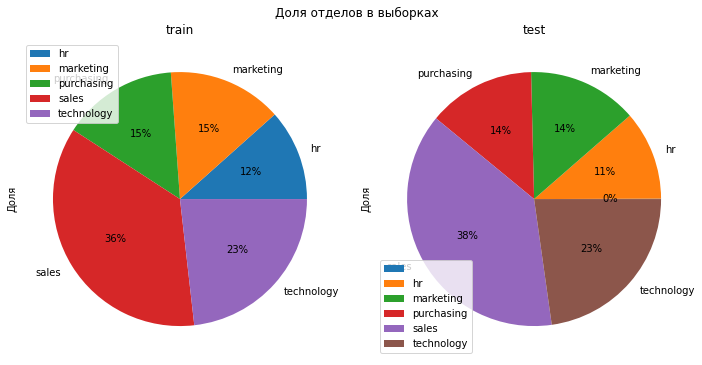

In [156]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='dept',
         suptitle='Доля отделов в выборках'
)

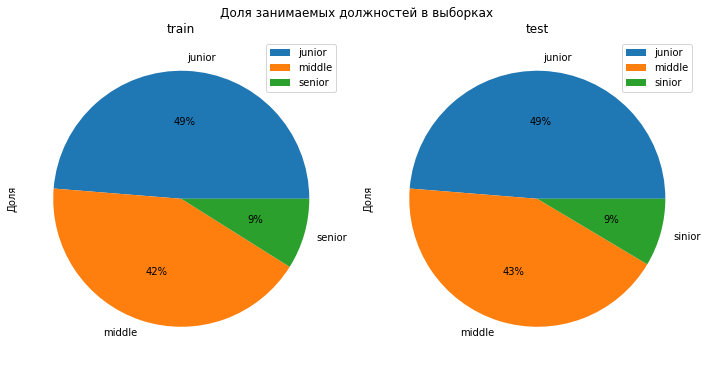

In [157]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='level',
         suptitle='Доля занимаемых должностей в выборках'
)

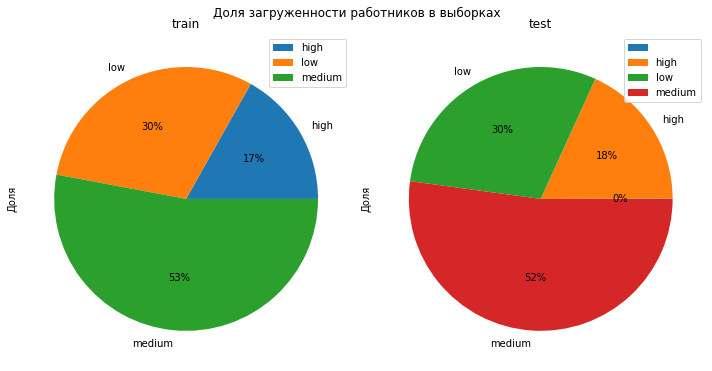

In [158]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='workload',
         suptitle='Доля загруженности работников в выборках'
)

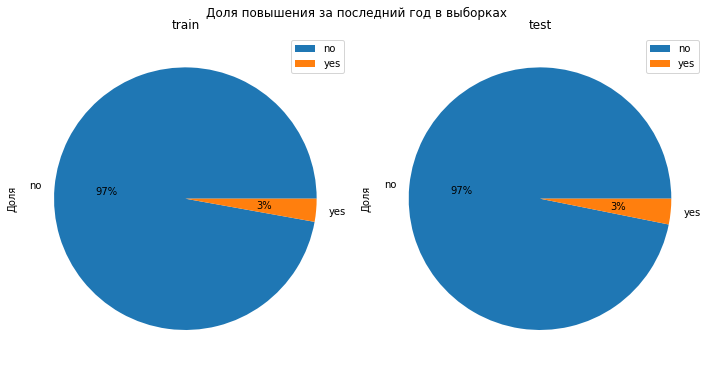

In [159]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='last_year_promo',
         suptitle='Доля повышения за последний год в выборках'
)

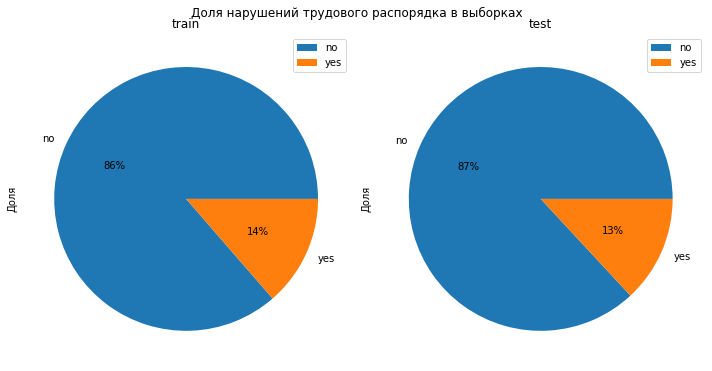

In [160]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='last_year_violations',
         suptitle='Доля нарушений трудового распорядка в выборках'
)

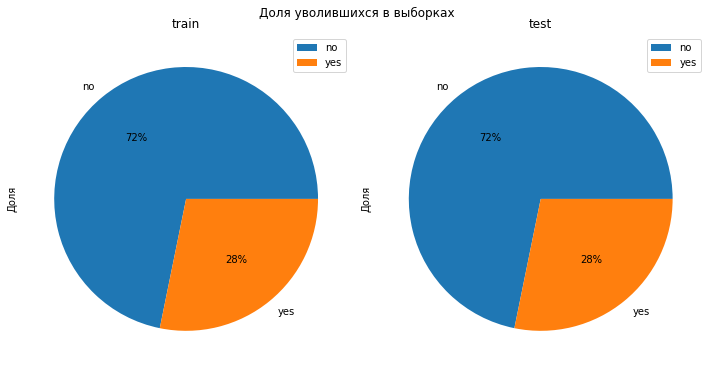

In [161]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='quit',
         suptitle='Доля уволившихся в выборках'
)

**Промежуточный вывод по исследовательскому анализу данных**

Проведенный исследовательский анализ данных указывает на совпадение данных в обучающей и тестовой выборках, что позволяет продолжить работу. При этом необходимо учесть следующие моменты:

+ Данные `id` переведены в индекс и отсортированы по возрастанию.
+ В данных обнаружены выбросы.
+ В колонках `dept`, `level`, `workload` требуется заменить пропуски.
+ Три признака: `dept`, `last_year_promo`, `last_year_violations` — необходимо кодировать с помощью `OneHotEncoder`.
+ Два признака: `level`, `workload` — требуется кодировать с помощью `OrdinalEncoder`.
+ Три признака: `employment_years`, `supervisor_evaluation`, `salary` — необходимо масштабировать.
+ Целевой признак перевести к числовым значениям: `1` — `yes` (уволился), `0` — `no` (работает).
Заполнение пропусков, кодирование и масштабирование будут проведены в пайплайне.

### Портрет уволившегося сотрудника

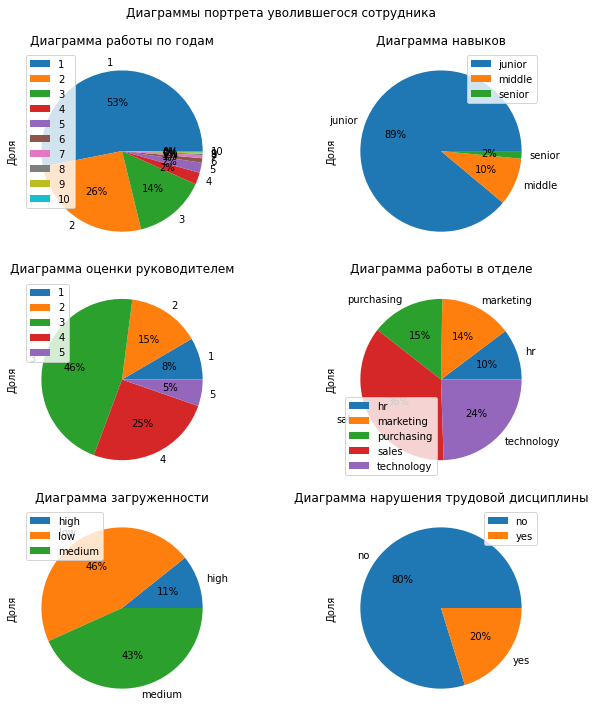

In [162]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 5))
fig.suptitle('Диаграммы портрета уволившегося сотрудника', x=0.5, y=0.99, fontsize=12)

(
train_quit.query('quit == "yes"') 
.pivot_table(index='employment_years',values='id',aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=axes[0,0], 
label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='level',values='id',aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=axes[0,1], 
label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='supervisor_evaluation',values='id',aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=axes[1,0], 
label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='dept',values='id',aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=axes[1,1], 
label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='workload',values='id',aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=axes[2,0], 
label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='last_year_violations',values='id',aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=axes[2,1], 
label='Доля')
)

axes[0,0].set_title('Диаграмма работы по годам')
axes[0,1].set_title('Диаграмма навыков')
axes[1,0].set_title('Диаграмма оценки руководителем')
axes[1,1].set_title('Диаграмма работы в отделе')
axes[2,0].set_title('Диаграмма загруженности')
axes[2,1].set_title('Диаграмма нарушения трудовой дисциплины')
plt.tight_layout()
plt.show()

In [163]:
train_quit.pivot_table(index = 'quit', values = 'salary', aggfunc = 'median')

,salary
quit,
no,34800
yes,22800


**На основе анализа данных можно сделать следующие выводы о портрете уволившегося сотрудника:**

+ Вероятность того, что сотрудник проработал всего год, составляет 53%.
+ С вероятностью 89% сотрудник имеет уровень навыков `junior`.
+ Оценка руководителя для такого сотрудника — 3 из 5 баллов с вероятностью 46%.
+ Вероятность того, что сотрудник работал в отделе `Sales`, составляет 36%, а в отделе `Technology` — 24%.
+ Загрузка сотрудника с вероятностью 46% была на уровне `Low` и с вероятностью 43% — на уровне `Medium`.
+ Вероятность того, что сотрудник нарушал трудовую дисциплину в течение года, составляет 20%.
+ Медианная заработная плата уволившегося сотрудника — 22 800, тогда как у продолжающих работать — 34 800.

### Влияние уровеня удовлетворённости сотрудника работой на его увольнение

Проведем объединение целевых признаков по `id`.

In [164]:
p_df = pd.merge(test_target_quit, test_target_job_satisfaction_rate, on='id', sort=True).sort_values(by='id')

Построим `гистограмму` и `boxplot` целевых признаков.

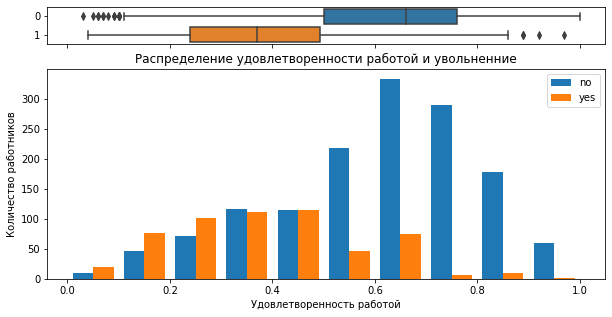

In [165]:
col = 'job_satisfaction_rate'
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10,5), gridspec_kw={"height_ratios": (.15, .85)})
 
sns.boxplot(data=[p_df[p_df['quit']=='no'][col], p_df[p_df['quit']=='yes'][col]], orient="h", ax=ax_box)
plt.hist([p_df[p_df['quit']=='no'][col], p_df[p_df['quit']=='yes'][col]], 
         bins=10, range=(0,1), label=['no', 'yes'])

plt.legend(loc='upper right')
plt.title('Распределение удовлетворенности работой и увольненние')
plt.xlabel('Удовлетворенность работой')
plt.ylabel('Количество работников')
plt.show()

Построим Плотность распределения (KDE) коэффициента удовлетворенности работой.

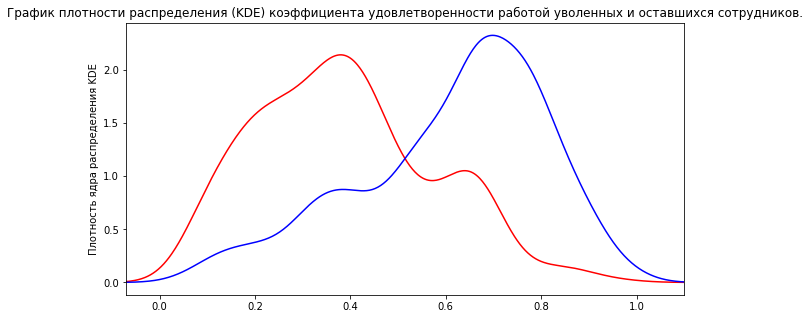

In [166]:
plt.figure(figsize=(10,5))
plt.title('График плотности распределения (KDE) коэффициента удовлетворенности работой уволенных и оставшихся сотрудников.')
plt.xlim (p_df['job_satisfaction_rate'].min()-0.1, p_df['job_satisfaction_rate'].max()+0.1)
ax = p_df[p_df['quit']=='yes']['job_satisfaction_rate'].plot.kde(color='red')
ax = p_df[p_df['quit']=='no']['job_satisfaction_rate'].plot.kde(color='blue')
ax.set_ylabel('Плотность ядра распределения KDE')
plt.show()

**Промежуточный вывод:**
На основе анализа гистограмм и боксплотов, отображающих плотность распределения уровня удовлетворённости работой, можно сделать вывод о наличии связи между этим показателем и увольнением сотрудников. В целом наблюдается тенденция: работники, которые выражают неудовлетворённость своей работой, склонны увольняться.

Выдвенем гипотезы:\
H0: Средние значения совокупной выборки равны, а значит зависимости между увольнением и удовлетворенностью работой нет.\
H1: Средние значения совокупной выборки не равны, а значит есть зависимости между увольнением и удовлетворенностью работой.

In [167]:
group1 = p_df[p_df['quit']=='yes']
group2 = p_df[p_df['quit']=='no']

print(ttest_ind(group1['job_satisfaction_rate'], group2['job_satisfaction_rate']))

print(ttest_ind(group1['job_satisfaction_rate'], group2['job_satisfaction_rate'], equal_var= False ))

Ttest_indResult(statistic=-23.074784903634534, pvalue=1.231122066517193e-104)
Ttest_indResult(statistic=-23.795097591114747, pvalue=2.7708628031539788e-101)


Так как p-значение оказалось ниже 0,05, мы отвергаем нулевую гипотезу t-критерия. Это позволяет нам заключить, что средние значения в генеральной совокупности различаются, что указывает на наличие зависимости между увольнением сотрудников и их

## Добавление нового входного признака

Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [168]:
train_quit['job_satisfaction_rate'] = rs.predict(train_quit)
test_features_2['job_satisfaction_rate'] = rs.predict(test_features_2)
train_quit.info(), test_features_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   quit                   4000 non-null   object 
 10  job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 343.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dt

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(None, None)

Дополнение таблиц новыми данными прошло успешно, пропуски в новых данных отсутствуют, проверим корреляционную взаимосвязь данных.

Назначим индексом столбец `id`.

In [169]:
train_quit = train_quit.sort_values(by=['id']).set_index('id')
test_features_2 = test_features_2.sort_values(by=['id']).set_index('id')

Удалим полные дубликаты в тренировочной выборке после назначения `id` индексом, это должно положительно повлиять на процес обучения моделей.

In [170]:
print(train_quit.info(), '\n---------------------------------------')
train_quit = train_quit.drop_duplicates()
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 100222 to 999915
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   quit                   4000 non-null   object 
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 343.8+ KB
None 
---------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 100222 to 999915
Data columns (total 10 columns):
 #   Column                 Non-Null C

После удаления полных дубликатов обучающая выборка сократилась с 4000 строк до 2587.

Построим матрицу корреляции phi(k) тренировочной выборки.

In [171]:
interval_cols = ['salary',
                 'job_satisfaction_rate'
                ]

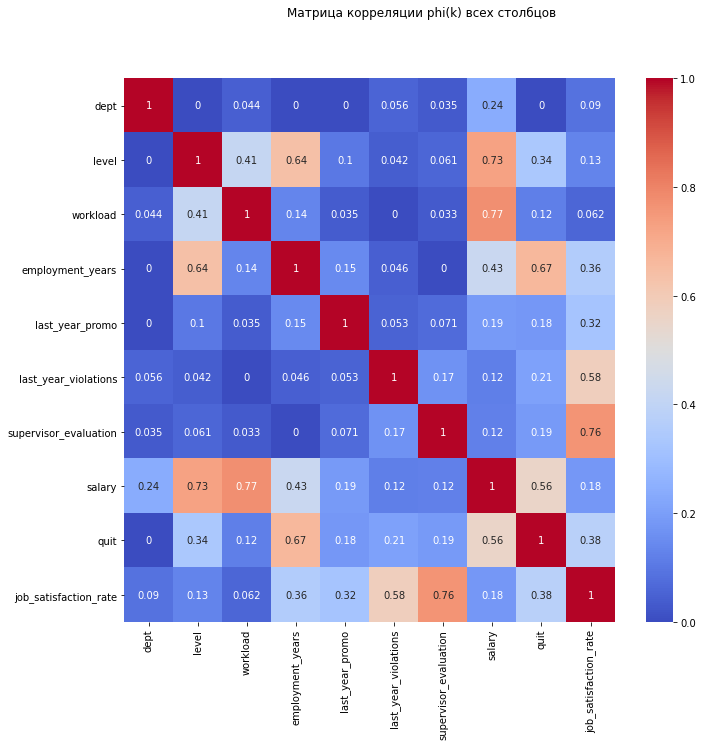

In [172]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(train_quit.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

Построим матрицу корреляции phi(k) тестовой выборки.

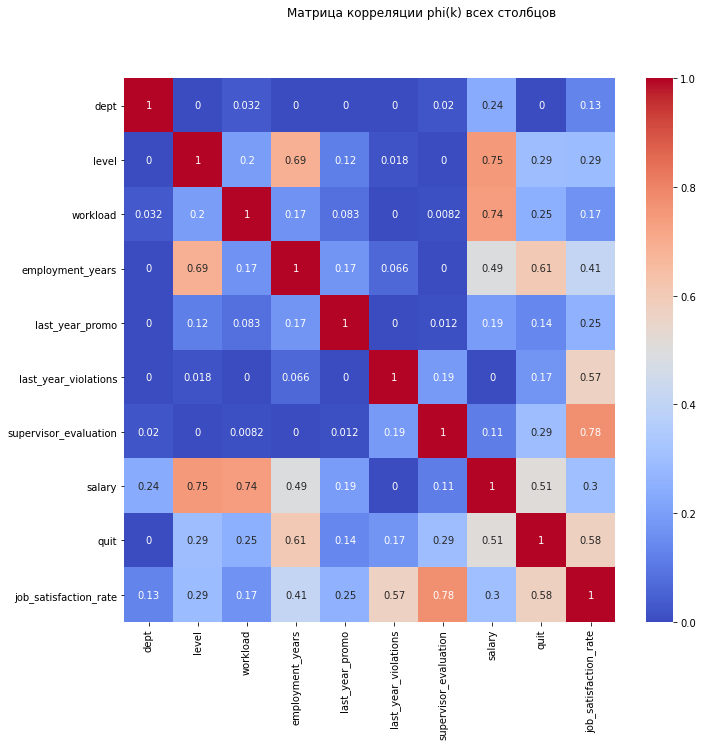

In [173]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(test_features_2.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

**Вывод по добавлению нового входного признака:**

1. Данные `id` переведены в индекс и отсортированы по возрастанию.
2. В данных обнаружены выбросы.
3. Между входными параметрами нет связи сильнее 0,9, поэтому при обучении модели мультиколлинеарность учитывать не нужно.
4. Значения корреляции на тренировочной и тестовой выборках немного отличаются, но в целом оценки соответствуют друг другу.
5. К исходным данным добавлен новый признак — уровень удовлетворённости работой `job_satisfaction_rate`, рассчитанный на основе лучшей модели.
6. В колонках `dept`, `level`, `workload` нужно заменить пропуски.
7. Три признака: `dept`, `last_year_promo`, `last_year_violations` — необходимо закодировать с помощью `OneHotEncoder`.
8. Два признака: `level`, `workload` — следует закодировать с помощью `OrdinalEncoder`.
9. Четыре признака: `employment_years`, `supervisor_evaluation`, `salary, job_satisfaction_rate` — нужно масштабировать.
Заполнение пропусков, кодирование и масштабирование будут выполнены в пайплайне.

## Подготовка данных

В подготовке данных к обучению модели добавляется признак `job_satisfaction_rate`, он содержит числовые значения и подлежит масштабированию, `ohe_columns`, `ord_columns` без изменений.

In [174]:
le = LabelEncoder()
le.fit_transform(train_quit['quit'].unique())
print ('Значениям', le.classes_, 'назначено соответственно', le.transform(le.classes_))
train_quit['quit'] = le.transform(train_quit['quit'])
test_features_2['quit'] = le.transform(test_features_2['quit'])

Значениям ['no' 'yes'] назначено соответственно [0 1]


In [175]:
X_train_2 = train_quit.drop('quit', axis=1)
y_train_2 = train_quit['quit'] 
X_test_2 = test_features_2.drop('quit', axis=1)
y_test_2 = test_features_2['quit']

num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

Переопределение `data_preprocessor`.

In [176]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [177]:
X_train_2_transformed = pd.DataFrame(data_preprocessor.fit_transform(X_train_2), columns=data_preprocessor.get_feature_names_out())
X_test_2_transformed = pd.DataFrame(data_preprocessor.transform(X_test_2), columns=data_preprocessor.get_feature_names_out())

X_train_2_transformed.info(), X_test_2_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2587 entries, 0 to 2586
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ohe__dept_marketing            2587 non-null   float64
 1   ohe__dept_purchasing           2587 non-null   float64
 2   ohe__dept_sales                2587 non-null   float64
 3   ohe__dept_technology           2587 non-null   float64
 4   ohe__last_year_promo_yes       2587 non-null   float64
 5   ohe__last_year_violations_yes  2587 non-null   float64
 6   ord__level                     2587 non-null   float64
 7   ord__workload                  2587 non-null   float64
 8   num__employment_years          2587 non-null   float64
 9   num__supervisor_evaluation     2587 non-null   float64
 10  num__salary                    2587 non-null   float64
 11  num__job_satisfaction_rate     2587 non-null   float64
dtypes: float64(12)
memory usage: 242.7 KB
<class 'pa

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(None, None)

In [178]:
X_train_2_transformed.head()

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary,num__job_satisfaction_rate
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.25,-1.0,-0.578947,-0.525714
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.25,0.0,-0.526316,-0.514286
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.75,1.0,-0.210526,0.314286
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.00,1.0,1.526316,0.428571
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.50,1.0,-0.368421,0.910714


**Вывод по подготовке данных**
 
Использовано два кодировщика, осуществлен визуальный контроль подготовки данных в пайплайне.

## Обучение модели

Поиск лучшей модели перебором всех моделей и их параметров.

In [179]:
# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(random_state=RANDOM_STATE, probability=True))
])

param_grid = [
    # Словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__criterion': ['gini', 'entropy', 'log_loss'],
        'models__splitter': ['best', 'random'],
        'models__max_depth': [None] + [i for i in range(2, 7)], #range(1, 700),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(2, 10),
        'models__max_leaf_nodes': range(1, 270),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
                                   
    # Словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # Словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # Словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print ('Метрика лучшей модели на на кросс-валидации:', rs.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

Отберем лучшую модель по лучшей характиристике на кросс - валидации.

In [180]:
all_model_2 = pd.DataFrame(rs.cv_results_).sort_values(by=['rank_test_score']).head(1)
all_model_2[['rank_test_score', 'mean_test_score', 'param_models', 'params']]         

,rank_test_score,mean_test_score,param_models,params
2,1,0.905104,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': RobustScaler(), 'models_..."


Выведем значимость признаков для модели `DecisionTreeClassifier`.

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


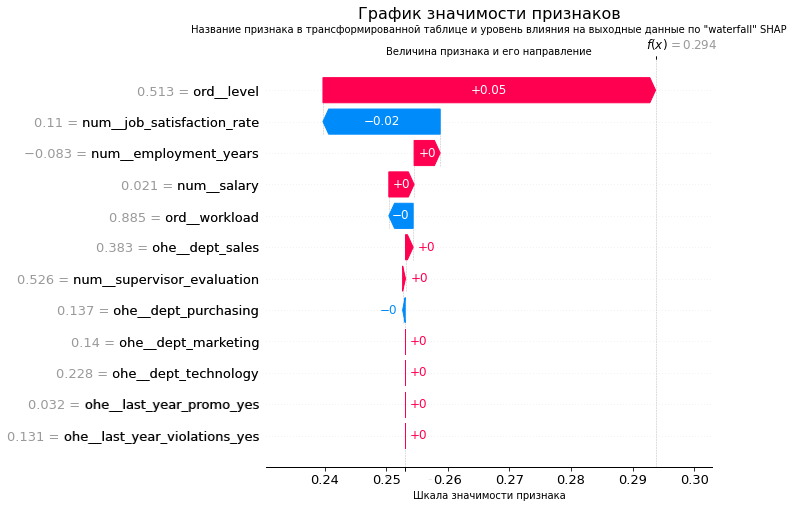

In [181]:
best_model = rs.best_estimator_

X_transformed = pd.DataFrame(data_preprocessor.transform(X_test_2), columns=data_preprocessor.get_feature_names_out())

explainer = shap.TreeExplainer(best_model.named_steps['models'])

shap_values = explainer(X_transformed)

shap_values_sum = 0
for i in range(1, len(shap_values)):
    shap_values_sum += shap_values[i]
    
shap.plots.waterfall(((shap_values_sum / len(shap_values))[:,1]), max_display=20, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_title('График значимости признаков', fontsize=16)
ax.set_xlabel('Название признака в трансформированной таблице и уровень влияния на выходные данные по "waterfall" SHAP')
ax.set_ylabel('Урые данные модели)', fontsize=14)

cb_ax0 = fig.axes[0] 
cb_ax0.set_xlabel('Шкала значимости признака')

cb_ax1 = fig.axes[1] 
cb_ax1.tick_params( labelsize=0)
cb_ax1.set_xlabel('Величина признака и его направление')

plt.show()


Проверим лучшую модель на соответствие условию: ROC-AUC ≥ 0.91 на тестовой выборке.

In [182]:
roc_auc_rs_test = roc_auc_score(y_test_2, rs.predict_proba(X_test_2)[:, 1])
if (roc_auc_rs_test >= 0.91):
    print ('Модель удовлетворяет условию: на тестовой выборке ROC-AUC', round(roc_auc_rs_test, 4), '>= 0.91')
else:
    print('Модель не удовлетворяет условию:  ROC-AUC на тестовой выборке >= 0.91 n\ ТРЕБУЕТСЯ ДОПОЛНИТЕЛЬНОЕ ИССЛЕДОВАНИЕ')

Модель удовлетворяет условию: на тестовой выборке ROC-AUC 0.9234 >= 0.91


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Отобранная модель соответствует условию.

In [183]:
dummy_class = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_class.fit(X_train_2, y_train_2)

roc_auc_rs_train = roc_auc_score(y_train_2, rs.predict_proba(X_train_2)[:, 1])
print(f'Значение ROC-AUC лучшей модели на обучающей выборке: {round(roc_auc_rs_train, 4)}')
roc_auc_rs_train = roc_auc_score(y_train_2, dummy_class.predict_proba(X_train_2)[:, 1])
print(f'Значение ROC-AUC модели `DummyClassifier` на обучающей выборке: {round(roc_auc_rs_train, 4)}')
print('-------------------------------')
roc_auc_rs_test = roc_auc_score(y_test_2, rs.predict_proba(X_test_2)[:, 1])
print(f'Значение ROC-AUC лучшей модели на тестовой выборке: {round(roc_auc_rs_test, 4)}')
roc_auc_rs_test = roc_auc_score(y_test_2, dummy_class.predict_proba(X_test_2)[:, 1])
print(f'Значение ROC-AUC модели `DummyClassifier` на тестовой выборке: {round(roc_auc_rs_test, 4)}')

Значение ROC-AUC лучшей модели на обучающей выборке: 0.9338
Значение ROC-AUC модели `DummyClassifier` на обучающей выборке: 0.5017
-------------------------------
Значение ROC-AUC лучшей модели на тестовой выборке: 0.9234
Значение ROC-AUC модели `DummyClassifier` на тестовой выборке: 0.5013


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Выводы

В процессе отбора была выбрана модель, которая соответствует требованию: `ROC-AUC` на тестовой выборке ≥ 0,91. Для модели `DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30, min_samples_leaf=3, min_samples_split=7, random_state=42)` этот показатель составил 0,9234.

Параметры модели: `{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss'}`.

Эта модель показала лучшие результаты в прогнозировании, поскольку при её создании было протестировано больше параметров, и она менее чувствительна к выбросам в данных.

Для выбранной модели определены наиболее значимые признаки (в порядке убывания важности):

`level` — уровень занимаемой должности.
`job_satisfaction_rate` — уровень удовлетворённости сотрудника работой.
`salary` — ежемесячная зарплата сотрудника.
`workload` — уровень загруженности сотрудника.
`employment_years` — длительность работы в компании.
Модель была проверена на адекватность. Её качество по метрике `ROC-AUC` значительно выше, чем у модели `DummyClassifier`:

Значение `ROC-AUC` лучшей модели на обучающей выборке: 0,9338.
Значение `ROC-AUC` модели `DummyClassifier` на обучающей выборке: 0,5017.

# Общий вывод

Задача заключалась в том, чтобы повысить эффективность управления персоналом и разработать рекомендации для бизнеса по предотвращению финансовых потерь, связанных с уходом сотрудников.

Задача решалась в 2 этапа:

1. Построение модели, которая предсказывает уровень удовлетворённости работой в компании
    1. Загрузка данных
        + Данные соответствуют описанным
    2. Предобработка данных
        + В колонках данные соответствуют типу
        + Дубликаты не обнаружены 
        + Выявлены пропуски в колонках `dept`и `level`, в колонках train_job_satisfaction_rate['dept'] и test_features['workload'] обнаружены пробелы, проведена замена пробелов `' '` на `np.nan`
        + исправлена ошибка `sinior` на `senior`
    3. Исследовательский анализ данных
        + данные `id`, переведены в индекс, отсортированы по возрастающей
        + в данных обнаружены выбросы
        + Между входными параметрами отсутствует связь выше 0,9 следовательно при обучении модели учитывать мультиколлинеарность не надо 
        + В колонках `dept`, `level`, `workload` необходимо заменить пропуски
        + Три признака: `dept`, `last_year_promo`, `last_year_violations` — нужно кодировать с помощью OneHotEncoder
        + Два признака: `level`, `workload` — нужно кодировать с помощью OrdinalEncoder
        + Три признака: `employment_years`, `supervisor_evaluation`, `salary` - достаточно масштабировать
    4. Подготовка данных
        + Заполнены пропуски
        + Проведено кодирование в соответствии с признаками (использовано два кодировщика `ohe - OneHotEncoder`, `ord - OrdinalEncoder`)
        + Проведено масштабирование данных
    5. Обучение моделей
        + В процессе работы отобрана лучшая модель: `DecisionTreeRegressor(max_features=9, random_state=42)` с параметрами: `{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=9, random_state=42)}`
        + Качество модели удовлетворяет критерию успеха SMAPE ≤ 15 на тестовой выборке: 14.3863
    6. Оформление выводов
        + В процессе обучения моделей и подбора параметров работа производилась для: LinearRegression() и  DecisionTreeRegressor()
        + В процессе работы отобрана лучшая модель: `DecisionTreeRegressor(max_depth=14, max_features=9, random_state=42)` с параметрами: `{'preprocessor__num': 'passthrough', 'models__max_features': 9, 'models__max_depth': 14, 'models': DecisionTreeRegressor(max_depth=14, max_features=9, random_state=42)}`
        + В процессе работы отбор модели производился по целевой функции SMAPE. Качество лучшей модели удовлетворяет: Критерию успеха SMAPE ≤ 15 на тестовой выборке: 14.7877
        + Линейная регрессия (LinearRegression()) показала менее эффективные результаты, поскольку анализ матрицы корреляции выявил отсутствие ярко выраженной линейной зависимости между входными и целевыми показателями — максимальное значение коэффициента корреляции составило 0,79. В то же время модель DecisionTreeRegressor() продемонстрировала лучшую адаптацию к данным во время обучения, успешно установив взаимосвязи между входными и целевыми параметрами.
        + Отобранная лучшая модель прошла проверку на адекватность
    
2. Построение модели, которая предсказывает увольнение сотрудника из компании
    1. Загрузка данных
        + Данные соответствуют описанным
    2. Предобработка данных
        + В колонках данные соответствуют типу
        + Дубликаты не обнаружены
        + Выявлены пропуски в колонках `dept`и `level`, в колонках `test_features['dept']` и `test_features['workload']` обнаружены пробелы, проведена замена пробелов `' '` на `np.nan`
        + исправлена ошибка `sinior` на `senior`    
    3. Исследовательский анализ данных
        + Принято решение провести повторное исследование данных так как в таблицах `train_job_satisfaction_rate` и `train_quit` значения в столбцах `id` не совпадают, а значит данные могут быть разными
        + Составили портрет уволившегося сотрудника: 
            + Начинающий сотрудник (отработал всего год) с вероятностью 53% 
            + Навыки работы - junior с вероятностью 89%
            + Оценен руководителем на 3 по 5-ти бальной шкале с вероятностью 46%
            + Является сотрудником отдела Sales с вероятностью 36%, отдела Technology - 24%
            + Загрузка сотрудника Low с вероятностью 46% и Medium - 43%
            + В течении года нарушал трудовую дисциплину с вероятностью 20%
            + Медианная заработная плата составляет 22800, в то время как продолживших работать 34800
        + Провели сопоставление признаков удовлетворенности работой и увольнением сотрудников. 
            + Построенные гистограммы с боксплотами и плотность распределения удовлетворенности работой, указывает на связь с увольнением сотрудников.
    4. Добавление нового входного признака
        + Добавили признак `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи
        + Проверили отсутствие наличия мультиколлениарности в данных
    5. Подготовка данных
        + При подготовке данных использовано два кодировщика, осуществлен визуальный контроль подготовки данных в пайплайне.
    6. Обучение модели
        + Проведенна настройка и поиск параметров модели в ручном и автоматическом режиме при помощи пайплайнов
        + Определены значимые признаки для лучшей модели `DecisionTreeClassifier` (по убыванию):
            1. level - `+` - уровень занимаемой должности
            2. job_satisfaction_rate - `-` - уровень удовлетворенности сотрудника работой
            3. salary - `+` - ежемесячная зарплата сотрудника
            4. workload - `-` - уровень загруженности сотрудника
            5. employment_years - `+` - длительность работы в компании
    + Оформлен вывод по разделу
        + В процессе отбора определили модель, которая удовлетворяет требованию: ROC-AUC на тестовой выборке ≥ 0.91 , при этом указанный показатель у модели `DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30, min_samples_leaf=3, min_samples_split=7, random_state=42)` = 0.9234. Её параметры `{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss'}`
        + Данная модель лучше справилась с прогнозированием, так как при её построении было перебрано больше параметров и на неё меньше оказывают влияния существующие выбросы в данных
        + Для указанной модели определены значимые признаки (по убыванию):
            1. level - `+` - уровень занимаемой должности
            2. job_satisfaction_rate - `-` - уровень удовлетворенности сотрудника работой
            3. salary - `+` - ежемесячная зарплата сотрудника
            4. workload - `-` - уровень загруженности сотрудника
            5. employment_years - `+` - длительность работы в компании

        + Модель оценена на адекватность, её качество по метрике ROC-AUC превосходит метрику модели `DummyClassifier`
            + Значение ROC-AUC лучшей модели на обучающей выборке: 0.9338
            + Значение ROC-AUC модели `DummyClassifier` на обучающей выборке: 0.5017
   
3. Общий вывод
    + Составлен данный вывод

## Рекомендации для бизнеса по снижению текучести кадров и оптимизации расходов


Для уменьшения количества увольнений и сокращения связанных с этим финансовых потерь предлагается сосредоточить усилия на ключевых факторах, которые в наибольшей степени влияют на решение сотрудников покинуть компанию (в порядке убывания значимости):

+ Уровень занимаемой должности (`level`): увольнения чаще всего происходят среди новичков. Чтобы снизить отток таких сотрудников, необходимо чётко обозначать перспективы карьерного роста и заинтересовывать их новыми возможностями.
+ Уровень удовлетворённости работой (`job_satisfaction_rate`): выявлена зависимость между удовлетворённостью работой и решением об увольнении. Рекомендуется провести дополнительное тестирование среди сотрудников, чтобы выяснить, что именно им не нравится в работе, и принять меры по устранению проблем.
+ Ежемесячная зарплата (`salary`): анализ показал, что увольняются сотрудники с медианной зарплатой ниже, чем у тех, кто остаётся работать. Следует пересмотреть систему оплаты труда и обеспечить конкурентоспособные условия.
+ Уровень загруженности (`workload`): загруженность влияет на решение об увольнении, причём больше склонны увольняться сотрудники с низкой загруженностью. Возможно, стоит рассмотреть возможность увеличения нагрузки в сочетании с повышением заработной платы.
+ Длительность работы в компании (`employment_years`): чем дольше сотрудник работает в компании, тем меньше вероятность его увольнения. Необходимо разработать программы для стимулирования и удержания молодых специалистов, которые проработали в компании менее двух лет.

Особое внимание следует уделить категории работников, которые наиболее склонны к увольнению:

+ сотрудники, отработавшие всего один год (вероятность увольнения — 53%);
+ специалисты с уровнем навыков `junior` (вероятность — 89%);
+ сотрудники, оценённые руководителем на 3 балла по пятибалльной шкале (вероятность — 46%);
+ работники отделов `Sales` (вероятность — 36%) и `Technology (вероятность — 24%);
+ сотрудники с низкой (`Low`) или средней (`Medium`) загрузкой (вероятности — 46% и 43% соответственно);
+ работники, нарушавшие трудовую дисциплину в течение года (вероятность — 20%);
+ сотрудники с медианной заработной платой 22 800, в то время как у продолжающих работать — 34 800.